In [55]:
import skimage as sk
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from skimage import io, feature, filters, color, restoration, util
from skimage.morphology import watershed
from skimage.future import graph
from scipy import ndimage as ndi

In [2]:
exec(open('/Users/kpuhger/Documents/count-cellula/src/heq.py').read())
exec(open('/Users/kpuhger/Documents/count-cellula/src/smoothing.py').read())

In [3]:
# load image
img_file = '/Users/kpuhger/Box Sync/count_cellula_imgs/SampleGFP.tif'
img = sk.io.imread(img_file)

next, we'll use adaptive equalization to enhance the image

In [4]:
# step 1 gaussian blur image
img_gauss = gaussian_blur(img, 5)

# step 2 perform adaptive equalization on blurred image
img_gauss_aeq = adapt_eq(img_gauss)

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


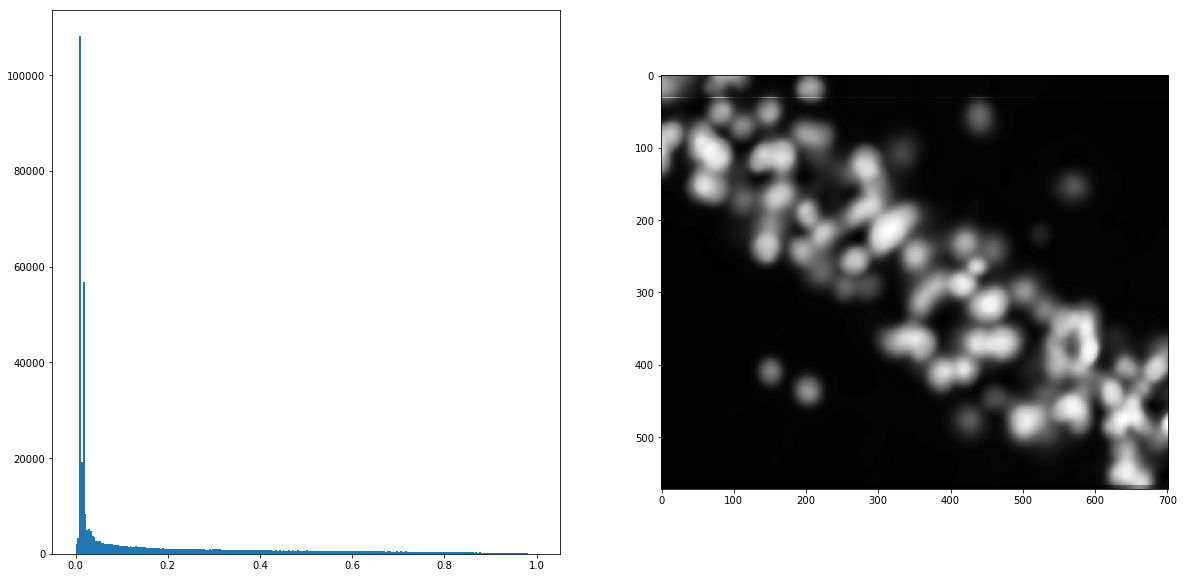

In [8]:
# test image
img_hist_stack(img_gauss_aeq, 9)

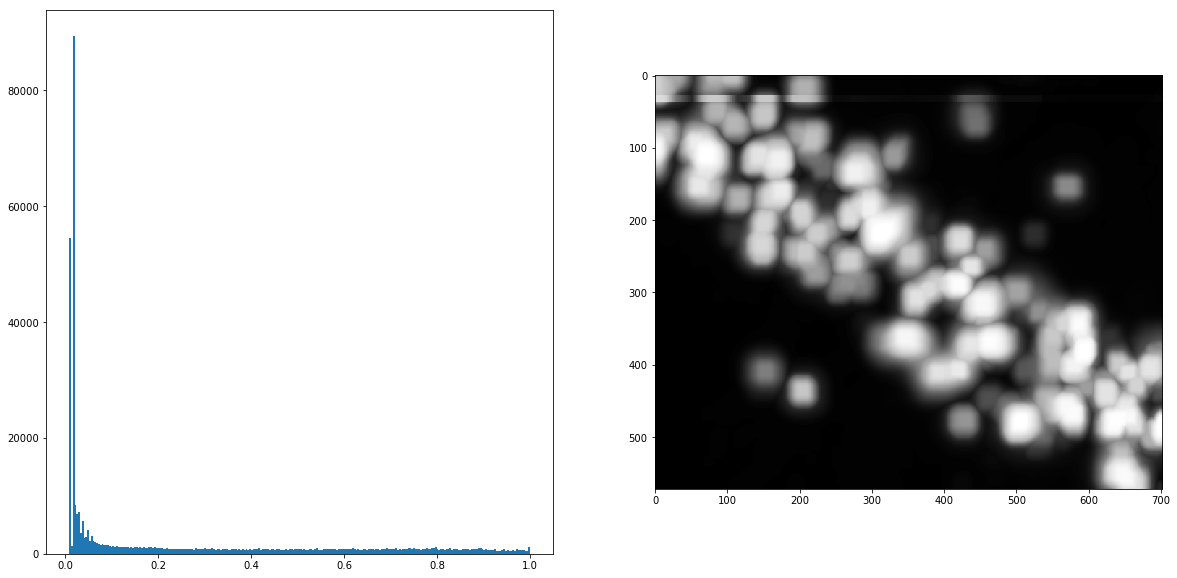

In [23]:
img_guass_aeq_lmax = ndi.maximum_filter(img_gauss_aeq, size = 10)

# test image
img_hist_stack(seeds_local_max, 9)

In [29]:
markers1 = rank.gradient(img_guass_aeq_lmax[9, :, :], disk(5)) < 10
markers1 = ndi.label(markers1)[0]

gradient1 = rank.gradient(img_guass_aeq_lmax[9, :, :], disk(2))

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [65]:
markers2 = np.empty_like(img_gauss_aeq)
for z in range(len(img_guass_aeq_lmax)):
    markers2[z, :, :] = rank.gradient(img_guass_aeq_lmax[z, :, :], disk(5)) < 10
    markers2[z, :, :] = ndi.label(markers2[z, :, :])[0]
    
gradient2 = np.empty_like(img_gauss_aeq)
for z in range(len(img_guass_aeq_lmax)):
    gradient2[z, :, :] = rank.gradient(img_guass_aeq_lmax[z, :, :], disk(2))
    

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [67]:
ws_test = watershed(gradient2, markers2)

In [101]:
# watershed by image
ws_test1 = np.empty_like(img_gauss_aeq)
for z in range(len(img_gauss_aeq)):
    ws_test1[z, :, :] = watershed(gradient2[z], markers2[z])

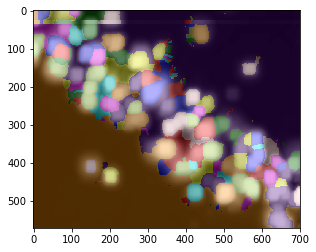

In [105]:
plt.imshow(color.label2rgb(ws_test1[11], img_guass_aeq_lmax[11, :, :]));

In [66]:
ws_test.shape

(572, 702)

In [78]:
def weight_boundary(graph, src, dst, n):
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']
    
    count = count_src + count_dst
    weighted_mean = (count_src * weight_src +
                     count_dst * weight_dst) / count

    return {'count': count, 'weight': weighted_mean}


def do_nothing(*args, **kwargs):
    pass

In [93]:
#
rag_graph = graph.rag_boundary(ws_test, markers2)
seg_cells = graph.merge_hierarchical(ws_test, rag_graph, thresh=0.00001, rag_copy=True,
                                     in_place_merge=True,
                                     merge_func=do_nothing,
                                     weight_func=weight_boundary)

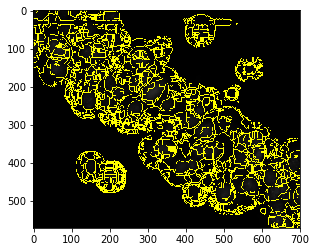

In [95]:
from skimage import segmentation
plt.imshow(segmentation.mark_boundaries(img[9, :, :], seg_cells[9, :, :]));

In [59]:
# seeds = peak_local_max(img_adapteq, min_distance=15, threshold_abs=0.9)

# f, ax = plt.subplots(1,1, figsize=(20,20));
# ax.imshow(img[9, :, :], cmap='gray');
# ax.plot(seeds[:, 1], seeds[:, 0], 'r.');